# [ICR] AutoFeat

 
今回のデータは数が少ないためAutoFeatを使って特徴量の水増しを試みた


# **Libraries**

In [12]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgbm
pd.set_option('display.max_columns', None)
import xgboost as xgb

from autofeat import AutoFeatClassifier

# **データのダウンロード**

In [5]:
train_df  = pd.read_csv('./data/train.csv')
test_df   = pd.read_csv('./data/test.csv')
greeks_df = pd.read_csv('./data/greeks.csv')
sample_submission = pd.read_csv('./data/sample_submission.csv')

# **Auto Featで特徴量エンジニアリングをする**

**まずはデータを整える**

カテゴリ値を数字にする

In [6]:
train_df['EJ'] = train_df['EJ'].replace('A', 0).replace('B', 1)
train_df['EJ']

0      1
1      0
2      1
3      1
4      1
      ..
612    0
613    1
614    0
615    1
616    0
Name: EJ, Length: 617, dtype: int64

In [7]:
test_df['EJ'] = test_df['EJ'].replace('A', 0).replace('B', 1)
test_df['EJ']

0    0
1    0
2    0
3    0
4    0
Name: EJ, dtype: int64

外れ値のある行を削除

In [8]:
train_df = train_df.drop(index=[160, 511])

欠損値を-999で埋める

In [9]:
all_cols = train_df.columns
non_use_cols = ['Id', 'Class']
feature_cols = [col for col in all_cols if col not in non_use_cols]
print(feature_cols)

['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL']


In [10]:
train_df[feature_cols] = train_df[feature_cols].fillna(-999)
test_df[feature_cols] = test_df[feature_cols].fillna(-999)

In [13]:
y = train_df['Class']
x = train_df[feature_cols]

X_train, X_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    train_size=0.8,
                                                    test_size=0.2,
                                                    random_state=42)

model = AutoFeatClassifier(verbose=1)
# 特徴量生成（学習データ利用）
X_train_feature_creation = model.fit_transform(X_train, y_train)

[AutoFeat] The 2 step feature engineering process could generate up to 77028 features.
[AutoFeat] With 492 data points this new feature matrix would use about 0.15 gb of space.
[feateng] Step 1: transformation of original features
[feateng] Generated 266 transformed features from 56 original features - done.
[feateng] Step 2: first combination of features


C:\Users\user\anaconda3\envs\ICR2\lib\site-packages\numpy\core\_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


[feateng] Generated 51364 feature combinations from 51681 original feature tuples - done.
[feateng] Generated altogether 51746 new features in 2 steps
[feateng] Removing correlated features, as well as additions at the highest level
[feateng] Generated a total of 28060 additional features
[featsel] Scaling data...done.
[featsel] Feature selection run 1/5
[featsel] Feature selection run 2/5
[featsel] Feature selection run 3/5
[featsel] Feature selection run 4/5
[featsel] Feature selection run 5/5
[featsel] 45 features after 5 feature selection runs
[featsel] 37 features after correlation filtering
[featsel] 5 features after noise filtering
[AutoFeat] Computing 5 new features.
[AutoFeat]     5/    5 new features ...done.
[AutoFeat] Final dataframe with 61 feature columns (5 new).
[AutoFeat] Training final classification model.
[AutoFeat] Trained model: largest coefficients:
[-3.08728916]
0.245278 * sqrt(EH)/GL
0.161741 * log(DY)/CC
0.122043 * AB/FS
0.003254 * FE/DA
0.000243 * log(FR)/FE


In [14]:
X_train_feature_creation

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,sqrt(EH)/GL,FE/DA,log(DY)/CC,log(FR)/FE,AB/FS
0,0.264926,4814.22458,85.200147,20.065463,8.891202,4.323192,0.066381,15.660470,5.032048,3843.509600,20.1267,191.687580,26.010925,864.601717,257.432377,35.284249,0.948640,50.342800,11.972417,0.023084,1.050225,0.735300,40.782209,0.987543,21.491108,39.51780,407.381360,0.238680,0.404484,146.204363,108.29384,24.723352,0.055176,1.74307,18.781052,10.326348,2.039686,773.332850,0.012168,1.0,109.125159,120.140143,69.161580,33.129600,1.139904,3126.235946,8.170266,6.443383,1.19016,0.074503,33.050006,295.064434,14377.722910,47.546938,54.333500,0.148500,0.742819,79.109564,3.091636,0.000056,3.555911
1,0.160238,2056.25464,92.689887,28.799003,8.138688,5.111643,0.025578,17.516409,1.229900,4602.507665,14.1240,163.820394,96.387605,571.140531,257.432377,93.394346,0.683038,85.646184,14.003805,0.028656,1.142518,0.945600,35.246596,1.348907,35.961880,55.03780,651.630115,0.238680,0.427714,130.487370,108.99662,28.425372,0.255189,2.00725,12.892040,4.926396,2.277515,973.007375,0.219024,1.0,109.125159,136.411873,21.116880,33.495168,3.140673,8991.898732,10.408544,2.121054,0.87754,0.440245,13.925094,72.611063,39292.976070,23.349275,75.212996,0.577946,0.809764,163.376783,3.742999,-0.000015,0.363973
2,1.042612,2808.77058,94.666830,36.479563,37.987536,6.954315,0.025578,13.839192,4.427640,3820.825990,26.8356,304.860402,155.448165,3639.320360,257.432377,87.204208,0.643732,260.751920,14.818793,0.042188,3.010645,0.741225,25.629450,0.628938,36.989336,7.19352,414.960775,0.238680,0.161247,410.479125,40.18460,33.949400,0.005518,1.74307,72.774892,4.926396,6.856731,3008.523500,0.003042,0.0,109.125159,78.526968,41.053848,185.997000,0.296850,4858.548748,7.492167,0.173229,3.24742,0.067730,44.556580,116.463039,134409.538300,35.178334,128.574280,21.978000,0.002510,675.406303,6.660178,0.000242,15.393651
3,0.431573,3351.64192,85.200147,17.652900,8.138688,5.643183,0.042630,12.938006,3.506972,6940.145960,24.3639,220.135509,123.721870,337.473710,257.432377,72.415889,0.951180,86.209072,26.508397,0.027064,1.152065,0.732825,13.784111,2.057841,40.342920,61.99464,337.144265,0.238680,0.409950,60.232470,163.11916,33.246528,0.005518,1.74307,19.692928,8.304900,2.664491,1092.085475,0.003042,0.0,37.049727,78.526968,38.395248,23.899008,0.296850,4642.936976,9.465821,0.173229,1.42100,0.656981,8.902014,236.490597,14688.014470,30.088006,35.447304,21.978000,0.002510,74.892555,3.133225,0.000076,0.656903
4,6.161666,18964.47278,210.557493,85.393581,8.138688,17.983770,0.032886,8.866914,6.767964,7259.050830,19.0674,1027.410669,344.644105,740.681903,1510.069965,536.221322,-999.000000,633.534408,50.082229,0.082386,2.195925,0.665475,46.868767,1.164087,7.030640,23.91632,416.264665,0.556686,0.314295,311.516100,65.77300,62.808096,0.005518,3.04325,16.287992,27.713628,6.360918,6845.912275,0.003042,0.0,-999.000000,110.708936,132.899616,-999.000000,0.296850,5676.738604,12.768108,0.173229,54.94862,-999.000000,31.636102,296.036174,12261.844150,49.586046,39.457052,21.978000,0.002510,237.358365,-0.002793,0.000706,-0.006168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,0.602493,5557.12344,100.797966,46.904065,8.138688,5.767209,0.025578,12.389732,9.347240,7900.152450,18.7143,136.741662,-999.000000,974.971771,257.432377,12.646816,0.629668,83.759320,18.995607,0.027064,1.304825,0.673875,38.946303,1.837161,7.030640,48.38748,379.117105,0.632502,0.519270,158.856645,94.98448,13.668472,0.524172,1.74307,47.610708,6.149160,5.155649,1212.940950,0.048672,1.0,-999.000000,81.307668,8.391048,42.354480,4.316199,5136.721022,9.625698,18.799615,0.49706,0.237055,26.733948,103.216456,642.540600,32.149440,39.436476,0.062526,3.

In [15]:
X_train_feature_creation.columns

Index(['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP',
       'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU',
       'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB',
       'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL',
       'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'sqrt(EH)/GL', 'FE/DA',
       'log(DY)/CC', 'log(FR)/FE', 'AB/FS'],
      dtype='object')

In [16]:
print("number of features in X_train:",  X_train.shape[1])                                   
print("number of features in X_train_feature_creation:", X_train_feature_creation.shape[1])

number of features in X_train: 56
number of features in X_train_feature_creation: 61


In [17]:
# テストデータの特徴量生成
X_test_feature_creation = model.transform(X_test)

[AutoFeat] Computing 5 new features.
[AutoFeat]     5/    5 new features ...done.


In [18]:
X_test_feature_creation

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,sqrt(EH)/GL,FE/DA,log(DY)/CC,log(FR)/FE,AB/FS
0,0.927241,8941.06389,514.858662,72.197264,35.121690,6.263313,0.097135,10.133616,5.854324,3747.62161,27.5418,274.059828,344.644105,471.649604,1310.734927,110.916988,0.746646,129.503880,2.803802,0.038208,1.050225,0.421950,40.815335,1.401318,7.030640,31.61424,168.463475,2.158650,0.393552,462.477540,71.93584,18.595400,3.627822,1.74307,18.893352,12.192300,1.378602,1385.843388,0.006084,1.0,109.125159,121.850274,68.222208,28.988400,0.296850,35125.281440,6.808555,27.212010,0.78561,0.927901,34.854594,172.342506,27313.911020,35.189497,111.642804,0.001129,69.070681,1111.058860,3.936015,-0.000007,0.999289
1,0.807597,2729.56519,129.189306,52.837917,8.138688,5.838081,0.026187,10.978084,1.229900,6272.85312,26.4825,142.553331,28.582060,408.773273,257.432377,12.499760,0.350505,61.552992,7.553844,0.044178,1.050225,0.593925,43.533451,0.479979,21.544652,65.03074,396.156375,0.238680,0.218640,60.232470,53.94764,23.276664,0.889713,1.74307,45.764496,6.976116,1.362478,2321.926550,0.225108,1.0,109.125159,81.052770,5.742576,192.545808,5.717331,6417.766515,12.889394,7.014830,0.80098,0.501202,19.245838,72.611063,31270.644540,35.714158,19.750388,0.170372,2.784819,98.688198,10.908582,-0.000035,1.611320
2,0.679407,5885.36377,85.200147,9.427268,8.138688,2.294481,0.025578,8.079164,1.229900,3196.66317,27.8949,235.417104,39.041135,804.108692,709.196735,23.198084,0.757570,36.532224,6.516863,0.031442,1.050225,0.175275,18.848979,0.452394,7.030640,12.94562,109.633200,0.238680,0.142116,60.232470,17.16564,13.347744,31.402041,1.74307,14.572048,9.305022,0.826355,185.594100,3.218436,1.0,109.125159,97.797219,3.828384,18.672528,74.699334,6078.639486,6.014683,38.083826,1.35662,0.067730,15.766890,118.826134,384.850764,16.435657,14.158860,0.069015,25.994291,469.551824,3.536444,0.000050,10.031109
3,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,21.1860,167.877117,27.287375,365.516874,257.432377,41.368691,0.691257,55.163024,4.780452,0.013930,1.177525,0.698250,40.159779,1.070298,7.030640,21.75904,355.930925,0.238680,0.445479,176.977590,90.91832,27.957928,0.005518,2.41906,32.508604,8.015112,1.354416,495.086300,0.003042,0.0,51.618996,78.526968,65.821872,29.708112,0.296850,17167.209610,9.879296,0.173229,1.26092,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000,0.002510,788.969073,5.036484,0.000014,2.208106
4,0.491395,2073.95694,90.355875,12.403485,8.138688,6.183582,0.112056,4.701292,1.229900,2156.50899,20.4798,94.923927,14.225905,455.701415,1419.724774,145.245373,0.461102,73.421208,2.901114,0.029850,1.050225,0.493275,50.226748,0.319986,7.030640,68.94372,237.121710,0.238680,0.073791,82.427145,37.84412,25.248800,0.006897,1.74307,7.407308,18.511092,2.575809,1532.338250,0.103428,1.0,109.125159,208.932529,3.828384,63.848736,1.870155,5452.001398,7.844999,0.439703,1.07706,0.555386,14.157644,72.611063,9797.235120,24.532553,13.724192,10.098000,0.031848,79.079014,4.342783,0.000014,0.884781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,0.756321,6958.02514,229.752129,161.796571,8.138688,6.785994,0.025578,8.999256,1.229900,4150.39751,20.1267,325.635741,33.911890,723.974565,257.432377,12.499760,0.470022,141.994444,13.669295,0.042188,1.050225,0.487350,22.763136,1.020645,7.030640,17.59580,178.029770,1.181466,0.240504,338.251365,56.05704,20.676720,0.005518,1.74307,20.822666,9.266148,1.096432,2462.375325,0.003042,0.0,109.125159,78.526968,12.680256,28.531440,0.296850,15786.469310,7.340560,0.173229,0.49706,0.521521,17.422646,72.611063,12353.929970,14.396549,35.894832,21.978000,0.002510,897.172582,6.459360,-0.000044,1.

In [19]:
# モデル構築
scores = []

model = xgb.XGBClassifier()
model.fit(X_train_feature_creation, y_train)

y_pred = model.predict(X_test_feature_creation)
score = log_loss(y_test, y_pred)
scores.append(score)
    
mean_score = sum(scores) / len(scores)
for i, score in enumerate(scores):
    print(f'Logloss_Score {i+1}: {score}')

print(f'Logloss_mean: {mean_score}' )

Logloss_Score 1: 1.1721513297273871
Logloss_mean: 1.1721513297273871


In [20]:

all_cols2 = X_train_feature_creation.columns
non_use_cols = ['Id', 'Class']
feature_cols2 = [col for col in all_cols2 if col not in non_use_cols]
print(feature_cols2)



['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'sqrt(EH)/GL', 'FE/DA', 'log(DY)/CC', 'log(FR)/FE', 'AB/FS']


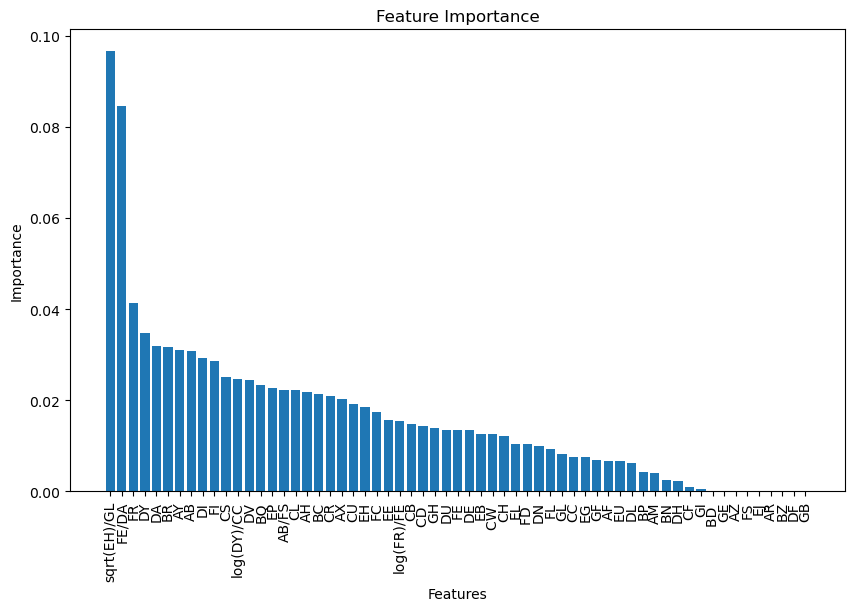

In [21]:

importance = model.feature_importances_
feature_names = feature_cols2

# 重要度の高い順に特徴量をソート
sorted_indices = importance.argsort()[::-1]
sorted_importance = importance[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

plt.figure(figsize=(10, 6))
plt.bar(sorted_feature_names, sorted_importance)
plt.xticks(rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()



In [ ]:
test_df.columns

In [ ]:
# 既存の特徴量と新しい特徴量のリスト
existing_cols = test_df.columns.tolist()
new_cols = ['sqrt(EH)/GL', 'FE/DA', 'log(BC)/DL', 'EH/AM', 'CD/CR', 'BQ/FD', 'AF/GE', '1/(AM*GL)', '1/(CC*EP)', 'log(FR)/FE', 'log(DV)/DA', 'log(EE)/CB', 'CD*log(CR)', 'log(DY)/CC']

for col in new_cols:
    if '/' in col:
        numerator, denominator = col.split('/')
        # ゼロ除算を回避するために、分母が0の場合は0を代入する
        test_df[col] = np.where(test_df[denominator] != 0, test_df[numerator] / test_df[denominator], 0)
    elif 'log(' in col and ')' in col:
        feature = col.split('log(')[1].split(')')[0]
        test_df[col] = np.log(test_df[feature])
    elif 'sqrt(' in col and ')' in col:
        feature = col.split('sqrt(')[1].split(')')[0]
        test_df[col] = np.sqrt(test_df[feature])
        
test_df.head()

In [ ]:
test = test_df.drop('Id', axis=1)

In [ ]:
pred = pd.DataFrame(model.predict_proba(test))


In [ ]:

sample_submission['Id']      = test_df.reset_index()['Id']
sample_submission["class_0"] = pred[0]
sample_submission["class_1"] = pred[1]
sample_submission.set_index('Id').to_csv('submission.csv')
sample_submission
